In [1]:
# Import OS module
import os

# Imports
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks, layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Notebook magic
%matplotlib inline

In [4]:
# Check if GPU available
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
# Configure variables for Transfer learning
image_size = 224
target_size = (image_size, image_size)
input_shape = (image_size, image_size, 3)
grid_shape = (1, image_size, image_size, 3)

batch_size = 32

In [6]:
dataset_root = "D:\\Piegonpea"

train_dir = os.path.join(dataset_root, "train")
test_dir = os.path.join(dataset_root, "valid")

In [7]:
# Define augmentations for train dataset and read the images
train_aug = ImageDataGenerator(
    # Rescale
    rescale=1/255.0,
    # Filling for W/H shift
    fill_mode="nearest",
    # Width and Height shift
    width_shift_range=0.2,
    height_shift_range=0.2,
    # Random zooms
    zoom_range=0.2,
    # Random Shearing aug
    shear_range=0.2,
)

# Read data from directory
train_data = train_aug.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 20177 images belonging to 15 classes.


In [8]:
# Get the list of categories in training data
cats = list(train_data.class_indices.keys())

In [9]:
# Augmentations for test data
test_aug = ImageDataGenerator(
    # Rescale
    rescale=1/255.0
)

# Read data from directory
test_data = test_aug.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 20176 images belonging to 14 classes.


In [10]:
# Load the base model
mbnet_v2 = keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=input_shape
)

# Stop from being trainable
mbnet_v2.trainable = False

In [11]:
# Define the layers
inputs = keras.Input(shape=input_shape)

# Get the layer
x = mbnet_v2(inputs, training = False)

# Stack layers further
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(len(cats), activation="softmax")(x)

# Combine the model
model = Model(inputs=inputs, outputs=x)

# Summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 15)                19215     
                                                                 
Total params: 2277199 (8.69 MB)
Trainable params: 19215 (75.0

In [12]:
# Compile
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Define callbacks to use
early_stopping_cb = callbacks.EarlyStopping(monitor="loss", patience=3)

In [ ]:
# Num epochs
epochs = 30

# Train model
history = model.fit(
    train_data,
    epochs=epochs,
    steps_per_epoch=150,
    callbacks=[early_stopping_cb]
)

Epoch 1/30


150/150 [==============================] - 212s 1s/step - loss: 0.9584 - accuracy: 0.6973
Epoch 2/30
150/150 [==============================] - 200s 1s/step - loss: 0.3927 - accuracy: 0.8731
Epoch 3/30
117/150 [======================>.......] - ETA: 3:45 - loss: 0.3143 - accuracy: 0.9012

In [14]:
model.evaluate(test_data)

631/631 [==============================] - 1384s 2s/step - loss: 0.1012 - accuracy: 0.9647


[0.10119771212339401, 0.964710533618927]

## Visualize the model history

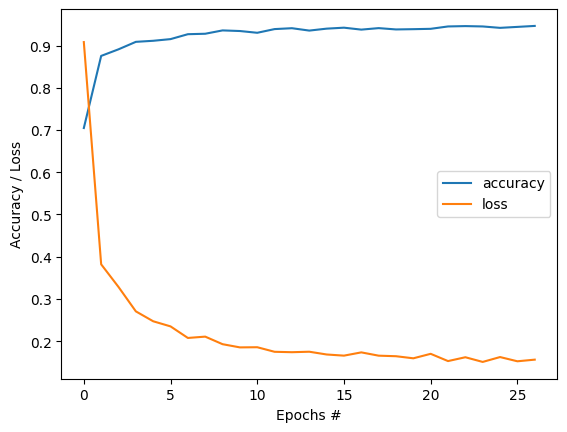

In [16]:
# Plotting
hist = history.history

# Plot accuracy and loss
plt.plot(hist["accuracy"], label="accuracy")
plt.plot(hist["loss"], label="loss")

if "val_accuracy" in hist and "val_loss" in hist:
    plt.plot(hist["val_accuracy"], label="val_accuracy")
    plt.plot(hist["val_loss"], label="val_loss")

# Add the labels and legend
plt.ylabel("Accuracy / Loss")
plt.xlabel("Epochs #")
plt.legend()

# Finally show the plot
plt.show()

## Save and download the model

We save the model to a file, and link it using IPython to easily get the assets.

In [17]:
model.save("plant_disease_detection.h5")

C:\Users\poorv\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
import json

from IPython.display import FileLink

# Link the files
FileLink("./plant_disease_detection.h5")

C:\Users\poorv\plant_disease_detection.h5

In [20]:
# Dump the categories
with open("categories.json", "w") as file:
  json.dump(train_data.class_indices, file)

# Link categories JSON
FileLink("categories.json")

C:\Users\poorv\categories.json

In [10]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the model
model = load_model('plant_disease_detection.h5')

# Load and preprocess the image
img_path = 'D:\\Piegonpea\\train\\Leaf_Spot_Pigeon\\als2.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Make predictions
predictions = model.predict(img_array)

class_mapping = {
  0: "Cherry_(including_sour)___Powdery_mildew",
  1: "Cherry_(including_sour)___healthy",
  2: "Corn_(maize)___healthy",
  3: "Grape___Black_rot",
  4: "Grape___Esca_(Black_Measles)",
  5: "Grape___healthy",
  6: "Healthy_Pigeon",
  7: "Leaf_Spot_Pigeon",
  8: "Moisaic_Pigeon",
  9: "Tomato___Bacterial_spot",
  10: "Tomato___Early_blight",
  11: "Tomato___Late_blight",
  12: "Tomato___Leaf_Mold",
  13: "Tomato___healthy"
}



# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Map the index to class name
predicted_class_name = class_mapping[predicted_class_index]

# Print the predicted class name
print("Predicted class:", predicted_class_name)


1/1 [==============================] - 1s 1s/step
Predicted class: Leaf_Spot_Pigeon
